In [1]:
%matplotlib inline
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF2DFM/
/home/ikeuchi/Share/GLOFRIM/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)

/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/input30min
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF2DFM/PCR


## create CMF model BMI object

In [6]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
print(CMF_engine)
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date, dt=86400)


/home/ikeuchi/Share/GLOFRIM/glofrim/cama-flood_bmi/src/libcama.so


## create DFM model BMI object

In [7]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date, dt=86400.)

/home/ikeuchi/Share/DFLOW-FM/dflowfm-1.1.267/lib/libdflowfm.so
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/delta/
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF2DFM/DFM


## intitialize DFM model

In [8]:
# initialize DFM first to expose model coordinates via BMI
DFM_bmi.initialize()

## couple grids based on CMF inpmat file

In [9]:
# couple grids
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## couple CMF to DFM based on 1d DFM indices

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

Text(0.5,1,u'CMF coupled to DFM mask')

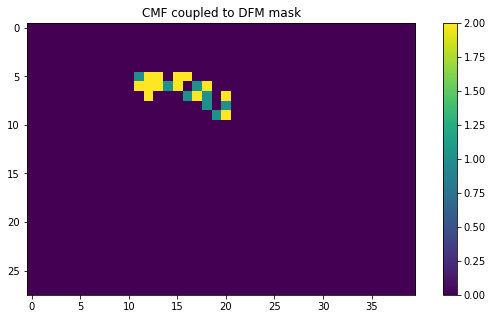

In [10]:
# get coupled dictionaries
CMF_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(CMF_bmi.coupled_mask, vmin=0, vmax=2)
plt.colorbar()
b.set_title('CMF coupled to DFM mask')

note there is a difference in DFM nodes and DFM coupled nodes as some are in unit catchments that are ignored by CMF. The runoff from PCR is however mass-conservative in the CMF runoff input.

In [11]:
len(DFM_bmi.model_1d_coords), len(DFM_bmi.coupled_idx)

(1428, 1425)

## initialize CMF and PCR models

In [12]:
# initialize CMF model after nextxy had been adapted
CMF_bmi.initialize()
# initialize model after ldd has been modified
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-19 11:23:41.565023
2018-03-19 11:23:41,828 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-19 11:23:41.565023
INFO: configuration.initialize_logging(): Logging output to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-19T11:23:41.565023.log
2018-03-19 11:23:41,838 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-19T11:23:41.565023.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-19 11:23:41,857 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" i

## define exchange of values in update states function

In [13]:
def get_CMF_delta_vol():
    # coupled 2d mask
    mask = (CMF_bmi.coupled_mask > 0).astype(float)
    # total Q inflow 2D for coupled cells
    q_in = (np.copy(CMF_bmi.get_var('rivinf')) + np.copy(CMF_bmi.get_var('fldinf'))) * mask # [m3/s]
    # total CMF converted runoff inflow 2D for coupled cells
    runoff = np.copy(CMF_bmi.get_var('runoff')) * mask # [m3/s]
    # take Qin + runoff in most upstream coupled cells, only runoff for other cells
    tot_flux = np.where(CMF_bmi.coupled_mask == 2, q_in + runoff, runoff)
    # convert flux to volume per day
    delta_vol = tot_flux * CMF_bmi.options['dt'] # [m3/day]
    return delta_vol 

def set_CMF_forcing():
    "coupling runoff between CMFan PCR model"
    runoff = np.copy(PCR_bmi.get_var('runoff')) # [m/day]
    runoff = np.where(np.isnan(runoff), 0, runoff)
    # note that runoff in (roffin) should be used to set PCR runoff. 
    CMF_bmi.set_var("roffin", runoff) # [m/dtin] = [m/d]

DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
CMFidx = CMF_bmi.coupled_idx
CMFfrac = CMF_bmi.coupled_area_frac

def set_DFM_forcing():
    CMF_delta_vol = get_CMF_delta_vol() # 2d array [m3/day]
    DFM_depth_conservative = CMF_delta_vol[CMFidx] * CMFfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    zerorain = np.zeros_like(np.copy(DFM_bmi.get_var('rain')))
    DFM_bmi.set_var('rain', zerorain)
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
        

## find location to record qsim from CMF on the fly

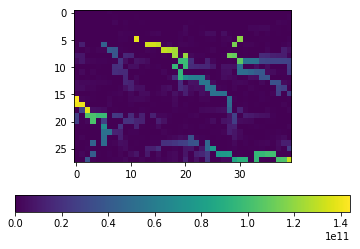

In [14]:
#- get upsteram area at comparison point in CMF
from os.path import join
upArea = np.fromfile(join(cwd, r'test_Elbe/CMF_Elbe/uparea.bin'), 'f').reshape(28,40)
plt.imshow(upArea)
plt.colorbar(orientation='horizontal')

In [15]:
#- check whether upstream area at chosen location is at the upper end
#- upstream area according to GRDC: 131950 km2 = 1.31950e11 m2
xCMFout = 6
yCMFout = 13
print (upArea[xCMFout, yCMFout])

1.34112e+11


## run coupled CMF - DFM model

In [16]:
# create file for writing CMF output
cmf_outFile = os.path.join(CMF_out_dir, 'qsim_CFM_at_location_' + str(xCMFout) + '_' + str(yCMFout) + '.txt')
cmf_of = open(cmf_outFile, 'w')
print (cmf_of)

<open file u'/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF2DFM/CMF/qsim_CFM_at_location_6_13.txt', mode 'w' at 0x7f8b63bbf6f0>


In [17]:
# run for numer of timesteps specified in set-file
tStart = datetime.now()
for i in range(timeSteps):
#for i in range(50):
    PCR_bmi.update()
    set_CMF_forcing()
    CMF_bmi.update()
    outflw_temp = np.copy(CMF_bmi.get_var('outflw'))[xCMFout, yCMFout]
    cmf_of.write(str(outflw_temp) + os.linesep)
    set_DFM_forcing()
    DFM_bmi.update()
tEnd = datetime.now()
cmf_of.close()

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-19 11:23:54,611 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-19 11:23:54,862 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-19 11:23:56,840 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-19 11:23:56,867 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-03-19 11:23:58,755 coupling_PCR_FM.model_functions_v2 INFO DFM -> 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
2018-03-19 11:25:24,087 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-09
2018-03-19 11:25:24,096 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09
INFO: pcrglobwb.update(): updating model to time 2000-01-09
2018-03-19 11:25:24,333 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-03-19 11:25:25,317 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-10 00:00:00, timestep 86400.0
2018-03-19 11:25:25,380 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
2018-03-19 11:27:13,709 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
2018-03-19 11:27:27,733 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-17
2018-03-19 11:27:27,741 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
INFO: pcrglobwb.update(): updating model to time 2000-01-17
2018-03-19 11:27:27,981 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-03-19 11:27:28,991 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
2018-03-19 11:29:18,151 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
2018-03-19 11:29:18,223 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
2018-03-19 11:29:32,615 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-25
2018-03-19 11:29:32,623 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-25
INFO: pcrglobwb.update(): updating model to time 2000-01-25
2018-03-19 11:29:32,836 pcrglo

2018-03-19 11:31:26,559 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
INFO: pcrglobwb.update(): updating model to time 2000-02-01
2018-03-19 11:31:26,806 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
2018-03-19 11:31:28,175 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
2018-03-19 11:31:28,247 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-03-19 11:31:43,391 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
2018-03-19 11:33:34,624 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-09
2018-03-19 11:33:34,631 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
INFO: pcrglobwb.update(): updating model to time 2000-02-09
2018-03-19 11:33:34,867 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
2018-03-19 11:33:35,864 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-10 00:00:00, timestep 86400.0
2018-03-19 11:33:35,924 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
2018-03-19 11:35:26,568 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
2018-03-19 11:35:40,858 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-17
2018-03-19 11:35:40,864 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
INFO: pcrglobwb.update(): updating model to time 2000-02-17
2018-03-19 11:35:41,109 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48
2018-03-19 11:35:42,101 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
2018-03-19 11:37:28,008 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
2018-03-19 11:37:28,067 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
2018-03-19 11:37:41,083 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-25
2018-03-19 11:37:41,089 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-25
INFO: pcrglobwb.update(): updating model to time 2000-02-25
2018-03-19 11:37:41,330 pcrglo

2018-03-19 11:39:22,785 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
INFO: pcrglobwb.update(): updating model to time 2000-03-03
2018-03-19 11:39:23,019 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
2018-03-19 11:39:24,023 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
2018-03-19 11:39:24,085 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
2018-03-19 11:39:36,634 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
2018-03-19 11:41:23,017 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-19 11:41:23,024 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-19 11:41:23,260 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-19 11:41:24,280 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
2018-03-19 11:41:24,347 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
2018-03-19 11:43:07,504 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
2018-03-19 11:43:23,068 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-19
2018-03-19 11:43:23,075 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-19
INFO: pcrglobwb.update(): updating model to time 2000-03-19
2018-03-19 11:43:23,320 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79
2018-03-19 11:43:24,369 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
2018-03-19 11:45:16,191 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
2018-03-19 11:45:16,255 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
2018-03-19 11:45:31,974 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-27
2018-03-19 11:45:31,981 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-27
INFO: pcrglobwb.update(): updating model to time 2000-03-27
2018-03-19 11:45:32,240 pcrglo

2018-03-19 11:47:30,044 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-03
INFO: pcrglobwb.update(): updating model to time 2000-04-03
2018-03-19 11:47:30,292 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
2018-03-19 11:47:31,338 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
2018-03-19 11:47:31,404 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
2018-03-19 11:47:46,625 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
2018-03-19 11:49:38,935 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-03-19 11:49:38,943 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11
INFO: pcrglobwb.update(): updating model to time 2000-04-11
2018-03-19 11:49:39,176 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
2018-03-19 11:49:40,162 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-12 00:00:00, timestep 86400.0
2018-03-19 11:49:40,227 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
2018-03-19 11:51:30,508 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
2018-03-19 11:51:44,483 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-19
2018-03-19 11:51:44,489 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
INFO: pcrglobwb.update(): updating model to time 2000-04-19
2018-03-19 11:51:44,739 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110
2018-03-19 11:51:45,760 coupling_PCR_FM.model_functions_v2 INFO PCR -

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
2018-03-19 11:53:42,816 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
2018-03-19 11:53:42,880 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-03-19 11:53:57,033 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-27
2018-03-19 11:53:57,039 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-27
INFO: pcrglobwb.update(): updating model to time 2000-04-27
2018-03-19 11:53:57,280 pc

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-04
2018-03-19 11:55:48,690 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-04
INFO: pcrglobwb.update(): updating model to time 2000-05-04
2018-03-19 11:55:48,933 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
2018-03-19 11:55:49,957 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
2018-03-19 11:55:50,007 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
2018-03-19 11:56:03,878 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
2018-03-19 11:57:43,482 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-12
2018-03-19 11:57:43,489 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-12
INFO: pcrglobwb.update(): updating model to time 2000-05-12
2018-03-19 11:57:43,733 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
2018-03-19 11:57:44,747 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-13 00:00:00, timestep 86400.0
2018-03-19 11:57:44,793 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
2018-03-19 11:59:06,387 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
2018-03-19 11:59:16,677 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-03-19 11:59:16,684 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-19 11:59:16,929 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-19 11:59:17,945 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-19 12:00:45,436 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
2018-03-19 12:00:46,473 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
2018-03-19 12:00:46,519 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-03-19 12:00:57,896 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-28
2018-03-19 12:00:57,902 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-04
2018-03-19 12:02:23,793 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-04
INFO: pcrglobwb.update(): updating model to time 2000-06-04
2018-03-19 12:02:24,038 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
2018-03-19 12:02:25,057 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
2018-03-19 12:02:25,106 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
2018-03-19 12:02:34,870 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
2018-03-19 12:04:02,569 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-12
2018-03-19 12:04:02,576 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-12
INFO: pcrglobwb.update(): updating model to time 2000-06-12
2018-03-19 12:04:02,838 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
2018-03-19 12:04:03,899 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-13 00:00:00, timestep 86400.0
2018-03-19 12:04:03,962 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
2018-03-19 12:05:30,952 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
2018-03-19 12:05:41,708 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-20
2018-03-19 12:05:41,715 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-20
INFO: pcrglobwb.update(): updating model to time 2000-06-20
2018-03-19 12:05:41,963 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172
2018-03-19 12:05:43,011 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-19 12:07:10,216 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
2018-03-19 12:07:11,288 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
2018-03-19 12:07:11,341 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-03-19 12:07:22,629 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-19 12:07:22,635 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-05
2018-03-19 12:08:46,886 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-05
INFO: pcrglobwb.update(): updating model to time 2000-07-05
2018-03-19 12:08:47,152 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
2018-03-19 12:08:48,330 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
2018-03-19 12:08:48,391 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
2018-03-19 12:09:01,112 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
2018-03-19 12:10:34,725 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-13
2018-03-19 12:10:34,733 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-13
INFO: pcrglobwb.update(): updating model to time 2000-07-13
2018-03-19 12:10:35,006 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
2018-03-19 12:10:36,132 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-14 00:00:00, timestep 86400.0
2018-03-19 12:10:36,192 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
2018-03-19 12:12:09,966 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
2018-03-19 12:12:22,686 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-21
2018-03-19 12:12:22,693 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-21
INFO: pcrglobwb.update(): updating model to time 2000-07-21
2018-03-19 12:12:22,947 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203
2018-03-19 12:12:24,013 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-19 12:14:01,140 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-19 12:14:02,178 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
2018-03-19 12:14:02,225 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
2018-03-19 12:14:15,695 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-29
2018-03-19 12:14:15,702 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-05
2018-03-19 12:15:49,194 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
INFO: pcrglobwb.update(): updating model to time 2000-08-05
2018-03-19 12:15:49,455 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-03-19 12:15:50,525 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
2018-03-19 12:15:50,583 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
2018-03-19 12:16:02,620 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
2018-03-19 12:17:33,235 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-13
2018-03-19 12:17:33,242 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-13
INFO: pcrglobwb.update(): updating model to time 2000-08-13
2018-03-19 12:17:33,504 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
2018-03-19 12:17:34,594 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-14 00:00:00, timestep 86400.0
2018-03-19 12:17:34,650 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
2018-03-19 12:18:57,080 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
2018-03-19 12:19:07,419 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-21
2018-03-19 12:19:07,425 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-21
INFO: pcrglobwb.update(): updating model to time 2000-08-21
2018-03-19 12:19:07,682 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234
2018-03-19 12:19:08,717 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-19 12:20:32,306 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
2018-03-19 12:20:33,363 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
2018-03-19 12:20:33,422 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
2018-03-19 12:20:44,427 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-29
2018-03-19 12:20:44,434 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-19 12:22:14,393 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-19 12:22:14,645 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-19 12:22:15,686 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
2018-03-19 12:22:15,738 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
2018-03-19 12:22:26,946 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
2018-03-19 12:23:57,484 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-13
2018-03-19 12:23:57,490 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13
INFO: pcrglobwb.update(): updating model to time 2000-09-13
2018-03-19 12:23:57,716 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-03-19 12:23:58,670 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-14 00:00:00, timestep 86400.0
2018-03-19 12:23:58,719 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
2018-03-19 12:25:22,966 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-03-19 12:25:32,811 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-21
2018-03-19 12:25:32,818 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-21
INFO: pcrglobwb.update(): updating model to time 2000-09-21
2018-03-19 12:25:33,048 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265
2018-03-19 12:25:33,994 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-19 12:26:51,352 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
2018-03-19 12:26:52,393 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
2018-03-19 12:26:52,442 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
2018-03-19 12:27:03,139 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-29
2018-03-19 12:27:03,145 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-06
2018-03-19 12:28:24,235 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-06
INFO: pcrglobwb.update(): updating model to time 2000-10-06
2018-03-19 12:28:24,486 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
2018-03-19 12:28:25,543 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
2018-03-19 12:28:25,595 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
2018-03-19 12:28:36,244 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
2018-03-19 12:30:02,780 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-14
2018-03-19 12:30:02,787 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-14
INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-19 12:30:03,017 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-19 12:30:03,974 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
2018-03-19 12:30:04,028 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
2018-03-19 12:31:35,966 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-03-19 12:31:47,404 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-22
2018-03-19 12:31:47,410 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22
INFO: pcrglobwb.update(): updating model to time 2000-10-22
2018-03-19 12:31:47,670 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-03-19 12:31:48,729 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-19 12:33:02,541 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
2018-03-19 12:33:03,613 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
2018-03-19 12:33:03,657 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
2018-03-19 12:33:12,440 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-30
2018-03-19 12:33:12,447 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-06
2018-03-19 12:34:25,367 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-06
INFO: pcrglobwb.update(): updating model to time 2000-11-06
2018-03-19 12:34:25,628 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
2018-03-19 12:34:26,695 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
2018-03-19 12:34:26,740 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
2018-03-19 12:34:36,756 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
2018-03-19 12:35:52,523 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-14
2018-03-19 12:35:52,531 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-14
INFO: pcrglobwb.update(): updating model to time 2000-11-14
2018-03-19 12:35:52,793 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
2018-03-19 12:35:53,872 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-15 00:00:00, timestep 86400.0
2018-03-19 12:35:53,917 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
2018-03-19 12:37:15,177 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-03-19 12:37:25,638 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-22
2018-03-19 12:37:25,644 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
INFO: pcrglobwb.update(): updating model to time 2000-11-22
2018-03-19 12:37:25,909 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
2018-03-19 12:37:27,000 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-19 12:38:48,218 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
2018-03-19 12:38:49,300 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
2018-03-19 12:38:49,349 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
2018-03-19 12:38:59,886 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-30
2018-03-19 12:38:59,892 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-07
2018-03-19 12:40:23,184 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-07
INFO: pcrglobwb.update(): updating model to time 2000-12-07
2018-03-19 12:40:23,448 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
2018-03-19 12:40:24,525 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
2018-03-19 12:40:24,572 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
2018-03-19 12:40:34,892 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
2018-03-19 12:41:58,673 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-15
2018-03-19 12:41:58,679 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-15
INFO: pcrglobwb.update(): updating model to time 2000-12-15
2018-03-19 12:41:58,943 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
2018-03-19 12:42:00,037 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-16 00:00:00, timestep 86400.0
2018-03-19 12:42:00,088 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
2018-03-19 12:43:25,003 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
2018-03-19 12:43:35,941 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-19 12:43:35,949 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-19 12:43:36,224 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358
2018-03-19 12:43:37,307 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-19 12:45:01,928 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-03-19 12:45:02,937 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
2018-03-19 12:45:02,985 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
2018-03-19 12:45:13,385 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-31
2018-03-19 12:45:13,392 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

2018-03-19 12:45:14,955 model INFO Accumulated totalPotET days 1 to 366 in 2000 = 8.617103e+01 km3 = 5.778019e+02 mm
INFO: pcrglobwb.report(): Accumulated satExcess days 1 to 366 in 2000 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-19 12:45:14,960 model INFO Accumulated satExcess days 1 to 366 in 2000 = 0.000000e+00 km3 = 0.000000e+00 mm
INFO: pcrglobwb.report(): Accumulated snowMelt days 1 to 366 in 2000 = 3.682866e+00 km3 = 2.469469e+01 mm
2018-03-19 12:45:14,967 model INFO Accumulated snowMelt days 1 to 366 in 2000 = 3.682866e+00 km3 = 2.469469e+01 mm
INFO: pcrglobwb.report(): Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.140729e+01 km3 = 1.435421e+02 mm
2018-03-19 12:45:14,972 model INFO Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.140729e+01 km3 = 1.435421e+02 mm
INFO: pcrglobwb.report(): Accumulated actTranspiLow days 1 to 366 in 2000 = 1.169305e+01 km3 = 7.840534e+01 mm
2018-03-19 12:45:14,979 model INFO Accumulated actTranspiLow days 1 to 366 in 2000 = 1.169305e+01

2018-03-19 12:46:32,280 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-06, timestep 372
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-07 00:00:00, timestep 86400.0
2018-03-19 12:46:32,331 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
2018-03-19 12:46:44,137 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-07
2018-03-19 12:46:44,144 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-07
INFO: pcrglobwb.update(): updating model to time 2001-01-07
2018-03-19 12:46:44,417 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-07
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-01-14
2018-03-19 12:48:19,988 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380
2018-03-19 12:48:21,065 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-15 00:00:00, timestep 86400.0
2018-03-19 12:48:21,121 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
2018-03-19 12:48:33,751 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-15
2018-03-19 12:48:33,757 pcrgl

2018-03-19 12:50:12,547 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33436800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-22
2018-03-19 12:50:12,553 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-22
INFO: pcrglobwb.update(): updating model to time 2001-01-22
2018-03-19 12:50:12,792 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388
2018-03-19 12:50:13,771 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-23 00:00:00, timestep 86400.0
2018-03-19 12:50:13,818 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 12:51:49,323 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
2018-03-19 12:52:01,059 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-30
2018-03-19 12:52:01,067 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-30
INFO: pcrglobwb.update(): updating model to time 2001-01-30
2018-03-19 12:52:01,345 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
2018-03-19 12:52:02,443 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 12:53:38,202 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-06, timestep 403
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-07 00:00:00, timestep 86400.0
2018-03-19 12:53:38,257 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
2018-03-19 12:53:50,599 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-07
2018-03-19 12:53:50,606 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-07
INFO: pcrglobwb.update(): updating model to time 2001-02-07
2018-03-19 12:53:50,874 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-07
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-02-14
2018-03-19 12:55:27,374 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411
2018-03-19 12:55:28,472 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-15 00:00:00, timestep 86400.0
2018-03-19 12:55:28,533 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
2018-03-19 12:55:41,350 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-15
2018-03-19 12:55:41,356 pcrgl

2018-03-19 12:57:23,648 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36115200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-22
2018-03-19 12:57:23,655 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-22
INFO: pcrglobwb.update(): updating model to time 2001-02-22
2018-03-19 12:57:23,948 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419
2018-03-19 12:57:25,158 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-23 00:00:00, timestep 86400.0
2018-03-19 12:57:25,217 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 12:59:10,898 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
2018-03-19 12:59:24,021 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-02
2018-03-19 12:59:24,028 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-02
INFO: pcrglobwb.update(): updating model to time 2001-03-02
2018-03-19 12:59:24,318 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427
2018-03-19 12:59:25,477 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 13:01:04,979 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-09, timestep 434
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-10 00:00:00, timestep 86400.0
2018-03-19 13:01:05,035 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
2018-03-19 13:01:17,923 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-10
2018-03-19 13:01:17,934 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-10
INFO: pcrglobwb.update(): updating model to time 2001-03-10
2018-03-19 13:01:18,255 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-10
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-03-17
2018-03-19 13:02:57,789 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442
2018-03-19 13:02:58,891 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-18 00:00:00, timestep 86400.0
2018-03-19 13:02:58,944 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
2018-03-19 13:03:10,609 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-18
2018-03-19 13:03:10,616 pcrgl

2018-03-19 13:04:57,133 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38793600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-25
2018-03-19 13:04:57,140 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-25
INFO: pcrglobwb.update(): updating model to time 2001-03-25
2018-03-19 13:04:57,411 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450
2018-03-19 13:04:58,517 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-26 00:00:00, timestep 86400.0
2018-03-19 13:04:58,571 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 13:06:40,919 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
2018-03-19 13:06:53,890 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-02
2018-03-19 13:06:53,893 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-02
INFO: pcrglobwb.update(): updating model to time 2001-04-02
2018-03-19 13:06:54,309 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458
2018-03-19 13:06:55,418 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 13:08:39,200 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
2018-03-19 13:08:39,249 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
2018-03-19 13:08:53,502 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-10
2018-03-19 13:08:53,509 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-10
INFO: pcrglobwb.update(): updating model to time 2001-04-10
2018-03-19 13:08:53,793 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-10
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-04-17
2018-03-19 13:10:44,990 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473
2018-03-19 13:10:46,124 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-18 00:00:00, timestep 86400.0
2018-03-19 13:10:46,185 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
2018-03-19 13:11:00,200 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-18
2018-03-19 13:11:00,207 pcrgl

2018-03-19 13:12:50,693 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41472000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-25
2018-03-19 13:12:50,699 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-25
INFO: pcrglobwb.update(): updating model to time 2001-04-25
2018-03-19 13:12:50,976 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481
2018-03-19 13:12:52,101 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-26 00:00:00, timestep 86400.0
2018-03-19 13:12:52,164 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 13:14:41,583 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
2018-03-19 13:14:55,716 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-03
2018-03-19 13:14:55,723 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-03
INFO: pcrglobwb.update(): updating model to time 2001-05-03
2018-03-19 13:14:56,003 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489
2018-03-19 13:14:57,142 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 13:16:44,415 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-10, timestep 496
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-11 00:00:00, timestep 86400.0
2018-03-19 13:16:44,462 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
2018-03-19 13:16:58,877 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-11
2018-03-19 13:16:58,884 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-11
INFO: pcrglobwb.update(): updating model to time 2001-05-11
2018-03-19 13:16:59,165 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-11
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-05-18
2018-03-19 13:18:48,550 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
2018-03-19 13:18:49,679 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
2018-03-19 13:18:49,736 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
2018-03-19 13:19:04,266 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-19
2018-03-19 13:19:04,273 pcrgl

2018-03-19 13:20:50,583 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44150400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-26
2018-03-19 13:20:50,589 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-26
INFO: pcrglobwb.update(): updating model to time 2001-05-26
2018-03-19 13:20:50,868 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512
2018-03-19 13:20:52,007 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-27 00:00:00, timestep 86400.0
2018-03-19 13:20:52,058 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 13:22:20,489 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
2018-03-19 13:22:31,015 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-03
2018-03-19 13:22:31,021 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-03
INFO: pcrglobwb.update(): updating model to time 2001-06-03
2018-03-19 13:22:31,310 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520
2018-03-19 13:22:32,454 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 13:23:57,926 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-10, timestep 527
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-11 00:00:00, timestep 86400.0
2018-03-19 13:23:57,969 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
2018-03-19 13:24:08,605 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-11
2018-03-19 13:24:08,611 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-11
INFO: pcrglobwb.update(): updating model to time 2001-06-11
2018-03-19 13:24:08,899 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-11
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-06-18
2018-03-19 13:25:35,095 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535
2018-03-19 13:25:36,234 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-19 00:00:00, timestep 86400.0
2018-03-19 13:25:36,287 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
2018-03-19 13:25:47,488 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-19
2018-03-19 13:25:47,494 pcrgl

2018-03-19 13:27:19,263 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46828800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-26
2018-03-19 13:27:19,269 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-26
INFO: pcrglobwb.update(): updating model to time 2001-06-26
2018-03-19 13:27:19,564 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543
2018-03-19 13:27:20,714 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
2018-03-19 13:27:20,766 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 13:28:47,624 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
2018-03-19 13:28:58,113 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-04
2018-03-19 13:28:58,121 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-04
INFO: pcrglobwb.update(): updating model to time 2001-07-04
2018-03-19 13:28:58,418 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551
2018-03-19 13:28:59,576 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 13:30:16,426 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-11, timestep 558
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-12 00:00:00, timestep 86400.0
2018-03-19 13:30:16,470 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
2018-03-19 13:30:26,768 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-12
2018-03-19 13:30:26,775 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-12
INFO: pcrglobwb.update(): updating model to time 2001-07-12
2018-03-19 13:30:27,066 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-07-19
2018-03-19 13:31:55,763 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566
2018-03-19 13:31:56,914 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-20 00:00:00, timestep 86400.0
2018-03-19 13:31:56,980 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
2018-03-19 13:32:09,016 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-20
2018-03-19 13:32:09,024 pcrgl

2018-03-19 13:33:50,139 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49507200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-27
2018-03-19 13:33:50,146 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-27
INFO: pcrglobwb.update(): updating model to time 2001-07-27
2018-03-19 13:33:50,428 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
2018-03-19 13:33:51,544 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-28 00:00:00, timestep 86400.0
2018-03-19 13:33:51,601 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 13:35:31,003 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
2018-03-19 13:35:43,520 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-04
2018-03-19 13:35:43,527 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-04
INFO: pcrglobwb.update(): updating model to time 2001-08-04
2018-03-19 13:35:43,807 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582
2018-03-19 13:35:44,918 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 13:37:22,832 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-11, timestep 589
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-12 00:00:00, timestep 86400.0
2018-03-19 13:37:22,877 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
2018-03-19 13:37:34,998 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-12
2018-03-19 13:37:35,005 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-12
INFO: pcrglobwb.update(): updating model to time 2001-08-12
2018-03-19 13:37:35,294 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-08-19
2018-03-19 13:39:05,249 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597
2018-03-19 13:39:06,386 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-20 00:00:00, timestep 86400.0
2018-03-19 13:39:06,428 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
2018-03-19 13:39:17,558 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-20
2018-03-19 13:39:17,565 pcrgl

2018-03-19 13:40:47,317 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52185600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-27
2018-03-19 13:40:47,326 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-27
INFO: pcrglobwb.update(): updating model to time 2001-08-27
2018-03-19 13:40:47,637 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605
2018-03-19 13:40:48,860 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-28 00:00:00, timestep 86400.0
2018-03-19 13:40:48,919 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 13:42:26,741 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
2018-03-19 13:42:37,431 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-04
2018-03-19 13:42:37,438 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-04
INFO: pcrglobwb.update(): updating model to time 2001-09-04
2018-03-19 13:42:37,728 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
2018-03-19 13:42:38,850 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 13:44:02,283 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-11, timestep 620
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-12 00:00:00, timestep 86400.0
2018-03-19 13:44:02,331 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
2018-03-19 13:44:13,101 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-12
2018-03-19 13:44:13,108 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-12
INFO: pcrglobwb.update(): updating model to time 2001-09-12
2018-03-19 13:44:13,381 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-09-19
2018-03-19 13:45:54,670 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628
2018-03-19 13:45:55,796 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-20 00:00:00, timestep 86400.0
2018-03-19 13:45:55,843 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
2018-03-19 13:46:08,384 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-20
2018-03-19 13:46:08,391 pcrgl

2018-03-19 13:47:49,109 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-27
2018-03-19 13:47:49,115 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-27
INFO: pcrglobwb.update(): updating model to time 2001-09-27
2018-03-19 13:47:49,405 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636
2018-03-19 13:47:50,553 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-28 00:00:00, timestep 86400.0
2018-03-19 13:47:50,610 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 13:49:34,571 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
2018-03-19 13:49:48,082 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-05
2018-03-19 13:49:48,088 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-05
INFO: pcrglobwb.update(): updating model to time 2001-10-05
2018-03-19 13:49:48,375 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644
2018-03-19 13:49:49,509 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 13:57:46,346 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-12, timestep 651
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-13 00:00:00, timestep 86400.0
2018-03-19 13:57:46,414 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
2018-03-19 13:58:01,432 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-13
2018-03-19 13:58:01,439 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-13
INFO: pcrglobwb.update(): updating model to time 2001-10-13
2018-03-19 13:58:01,708 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-13
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-10-20
2018-03-19 13:59:54,530 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659
2018-03-19 13:59:55,557 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-21 00:00:00, timestep 86400.0
2018-03-19 13:59:55,608 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
2018-03-19 14:00:09,085 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-21
2018-03-19 14:00:09,091 pcrgl

2018-03-19 14:02:15,726 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57542400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-28
2018-03-19 14:02:15,734 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-28
INFO: pcrglobwb.update(): updating model to time 2001-10-28
2018-03-19 14:02:16,055 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667
2018-03-19 14:02:17,356 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-29 00:00:00, timestep 86400.0
2018-03-19 14:02:17,414 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 14:04:12,781 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
2018-03-19 14:04:25,668 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-05
2018-03-19 14:04:25,676 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-05
INFO: pcrglobwb.update(): updating model to time 2001-11-05
2018-03-19 14:04:25,999 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675
2018-03-19 14:04:27,312 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 14:06:04,741 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
2018-03-19 14:06:04,799 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
2018-03-19 14:06:16,535 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-13
2018-03-19 14:06:16,542 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-13
INFO: pcrglobwb.update(): updating model to time 2001-11-13
2018-03-19 14:06:16,867 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-13
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-11-20
2018-03-19 14:07:58,392 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690
2018-03-19 14:07:59,709 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-21 00:00:00, timestep 86400.0
2018-03-19 14:07:59,770 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
2018-03-19 14:08:12,853 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-21
2018-03-19 14:08:12,861 pcrgl

2018-03-19 14:09:55,604 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60220800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-28
2018-03-19 14:09:55,613 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-28
INFO: pcrglobwb.update(): updating model to time 2001-11-28
2018-03-19 14:09:55,925 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698
2018-03-19 14:09:57,252 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-29 00:00:00, timestep 86400.0
2018-03-19 14:09:57,317 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-19 14:11:34,842 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
2018-03-19 14:11:46,507 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-06
2018-03-19 14:11:46,514 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-06
INFO: pcrglobwb.update(): updating model to time 2001-12-06
2018-03-19 14:11:46,812 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706
2018-03-19 14:11:47,997 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-19 14:13:21,202 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-13, timestep 713
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-14 00:00:00, timestep 86400.0
2018-03-19 14:13:21,259 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
2018-03-19 14:13:33,335 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-14
2018-03-19 14:13:33,342 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-14
INFO: pcrglobwb.update(): updating model to time 2001-12-14
2018-03-19 14:13:33,647 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-14
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-12-21
2018-03-19 14:15:10,305 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
2018-03-19 14:15:11,350 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
2018-03-19 14:15:11,404 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
2018-03-19 14:15:23,534 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-22
2018-03-19 14:15:23,541 pcrgl

2018-03-19 14:17:00,750 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62899200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-29
2018-03-19 14:17:00,756 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-29
INFO: pcrglobwb.update(): updating model to time 2001-12-29
2018-03-19 14:17:01,049 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729
2018-03-19 14:17:02,211 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-30 00:00:00, timestep 86400.0
2018-03-19 14:17:02,257 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

In [18]:
tEnd = datetime.now()
cmf_of.close()

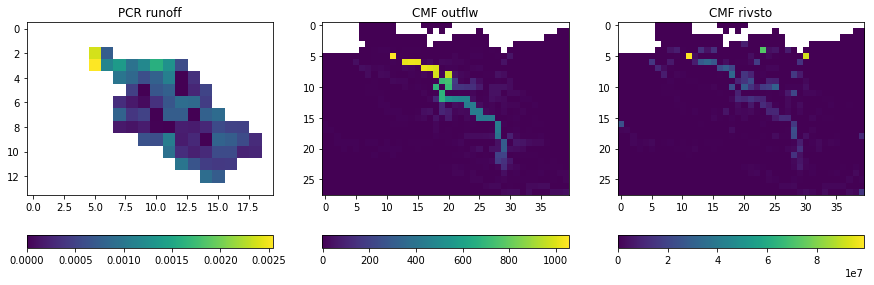

In [19]:
runoff = np.copy(PCR_bmi.get_var('runoff'))
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = np.copy(CMF_bmi.get_var('rivsto_out'))
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

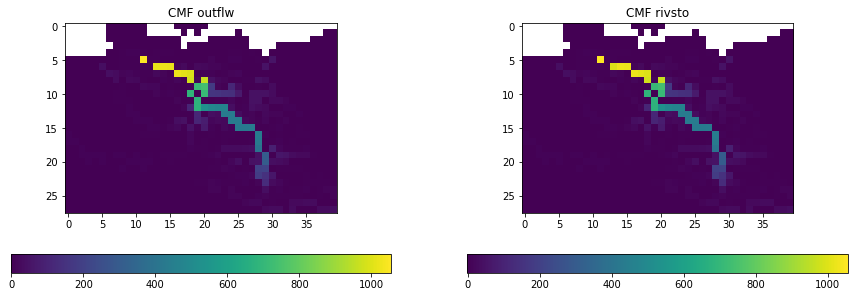

In [20]:
#- reassess location of CMF output point by comparing with simulated discharge
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
test = np.copy(outflw)
test[6,13] = 1000

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(test)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [21]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-19 11:23:54.611338
end time coupling:  2018-03-19 14:17:29.057854
average time per update PCR->CMF->DFM:  0:00:14.266365


## Finalize models

In [22]:
PCR_bmi.finalize()
CMF_bmi.finalize()
DFM_bmi.finalize()


INFO: wrapper.finalize(): cd /home/ikeuchi/Share/GLOFRIM/glofrim
2018-03-19 14:17:29,943 bmi.wrapper INFO cd /home/ikeuchi/Share/GLOFRIM/glofrim
INFO: wrapper.finalize(): cd /home/ikeuchi/Share/GLOFRIM/glofrim
2018-03-19 14:17:29,951 bmi.wrapper INFO cd /home/ikeuchi/Share/GLOFRIM/glofrim


## Compare model results

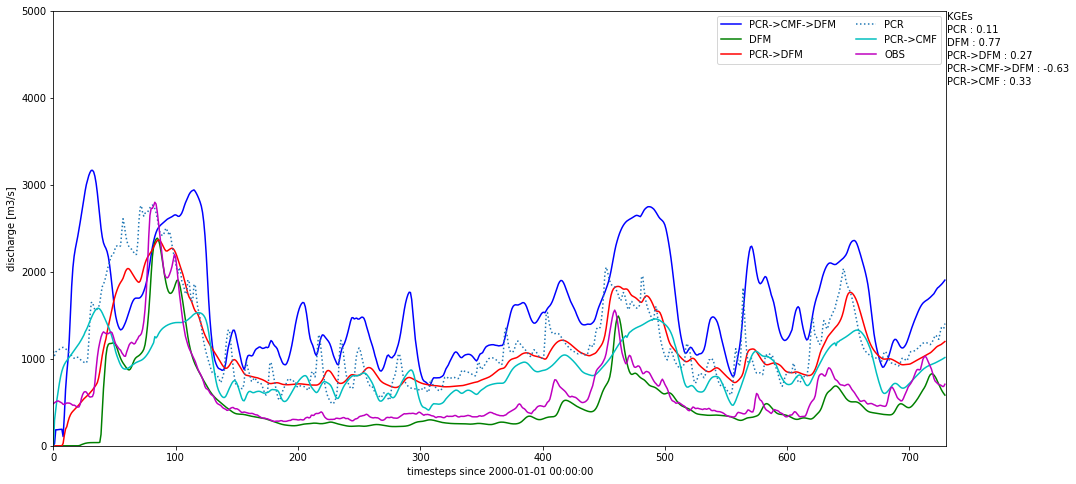

In [23]:
import matplotlib.dates as mdates
from netCDF4 import Dataset

#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
#- laod DFM output file (from 1way coupled PCR->DFM run)
fo_1way = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_1way_his.nc')
#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- load PCR file
po = os.path.join(cwd, 'test_Elbe/', 'Qsim_Elbe_Darchau_30min_2000s_industrial_prefactored.dump')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- estract PCR data
pd = np.loadtxt(po, unpack=True, skiprows=4)
PCR_ND = pd[1]
PCR_ND = PCR_ND[:]

#- extrat CMF data
cd = np.loadtxt(cmf_outFile, unpack=True)

#- extract simulated discharge from nc-file (for this run)
no = Dataset(fo, 'r')
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

#- extract simulated discharge from nc-file for 1way PCR->DFM
no_1way = Dataset(fo_1way, 'r')
qsim_1way = no_1way.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_1way = np.absolute(qsim_1way[:,2])
qsim_ND_1way = np.absolute(qsim_1way[:,0])
qsim_downBC_1way = np.absolute(qsim_1way[:,1])

#- extract simulated discharge from nc-file for DFM standalone
no_stA = Dataset(fo_stA, 'r')
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND), len(cd))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    PCR_ND = PCR_ND[:minLength]
    qsim_ND_1way = qsim_ND_1way[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    cd = cd[:minLength]

#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_1way = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_1way)
KGE_ND_1way = np.round(KGE_ND_1way,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)
KGE_ND_PCR = spotpy.objectivefunctions.kge(qobs_ND, PCR_ND)
KGE_ND_PCR = np.round(KGE_ND_PCR,2)
KGE_ND_CMF = spotpy.objectivefunctions.kge(qobs_ND, cd)
KGE_ND_CMF = np.round(KGE_ND_CMF,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qsim_ND_1way, 'r', label = 'PCR->DFM')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(PCR_ND, ':',label = 'PCR')
plt.plot(cd, c='c', label = 'PCR->CMF')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4750, 'PCR : '+str(KGE_ND_PCR))
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4450, 'PCR->DFM : '+str(KGE_ND_1way))
plt.text(len(qsim_ND)+1,4300, 'PCR->CMF->DFM : '+str(KGE_ND))
plt.text(len(qsim_ND)+1,4150, 'PCR->CMF : '+str(KGE_ND_CMF))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2CMF2DFM.png'), dpi=300)

Text(0.5,0,u'timesteps since 2000-01-01 00:00:00')

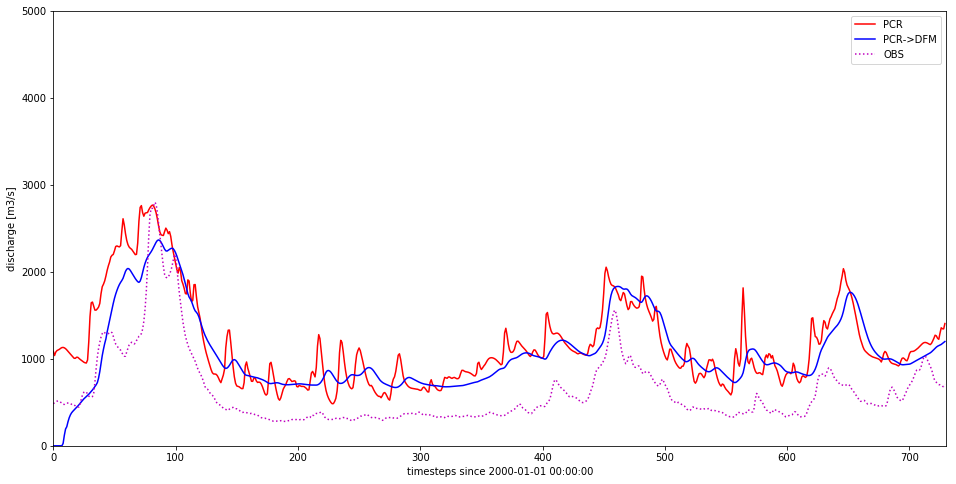

In [24]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

Text(0.5,0,u'timesteps since 2000-01-01 00:00:00')

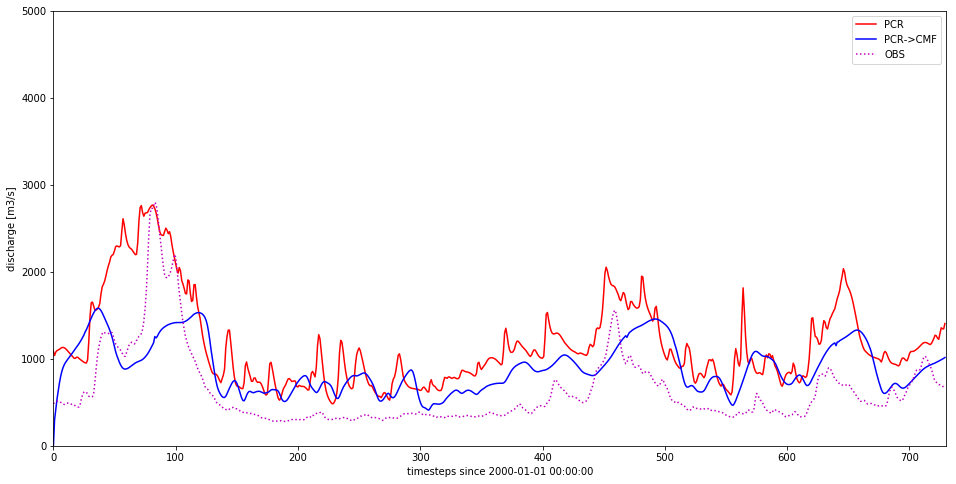

In [25]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

Text(0.5,0,u'timesteps since 2000-01-01 00:00:00')

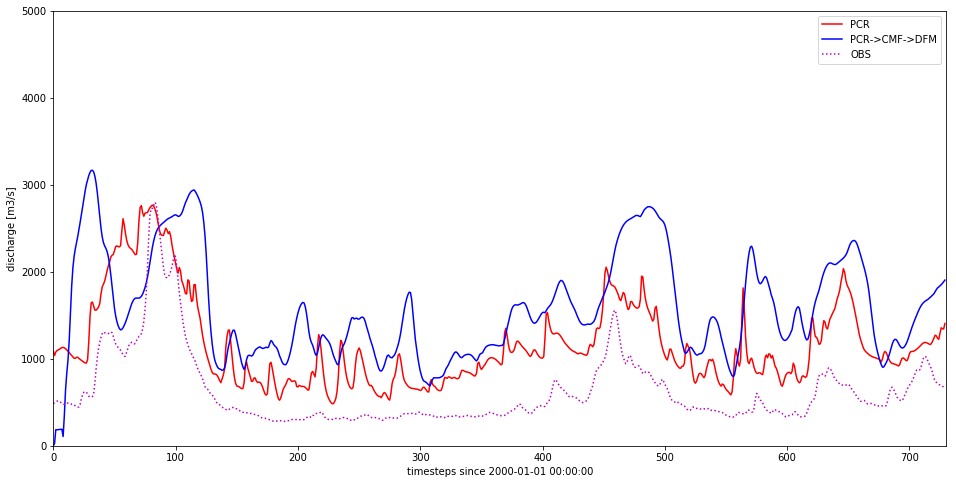

In [26]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

Text(0.5,0,u'timesteps since 2000-01-01 00:00:00')

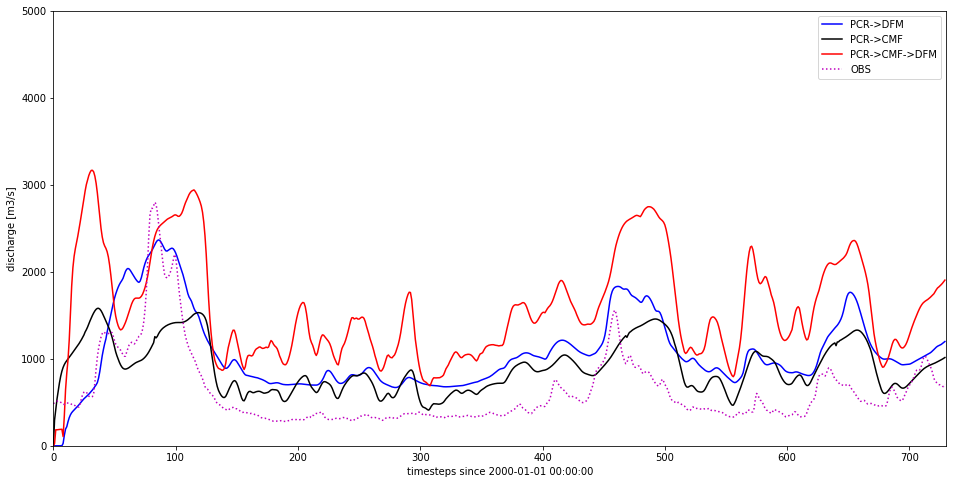

In [27]:
plt.figure(figsize=(16,8))
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.plot(cd, 'k', label = 'PCR->CMF')
plt.plot(qsim_ND, 'r', label = 'PCR->CMF->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))